In [1]:
import tensorflow.compat.v2 as tf
from tensorflow import keras
import qkeras
import numpy as np
import pandas as pd
import hls4ml
import matplotlib.pyplot as plt
import plotting
from tensorflow.keras.regularizers import l1
import os

##  Vivado2019.2 bin path on ITIV server
os.environ['PATH'] = '/tools/xilinx/ISE_EDK/Vivado/2019.2/bin:' + os.environ['PATH']

2023-04-22 02:56:20.923579: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-22 02:56:20.923611: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/updyh/miniconda3/envs/hls4ml-tutorial/lib/python3.8/site-packages/hls4ml/converters/__init__.py:16: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


## Create a dummy dataset


In [2]:
X = np.array(
   [
   [0,0],
   [0,1],
   [1,0],
   [1,1]  
   ] 
)

Y = np.array(
  [ [1],[2],[3],[4] ]     
)

print(X.shape)
print(Y.shape)

(4, 2)
(4, 1)


## Function to Create a dummy HLS4ML QMLP

In [3]:
def create_vertex_Qcnn(
             
    input_shape = (2),             
    output_size = 1,
     
    # Dense 
    neurons_per_dense_layer = [],  # int in list,
    
    # Dense Quantization
    dense_weight_quantizer = [],   # string in list
    dense_bias_quantizer  = [],     # string in list
    dense_activation_quantizer = [], #string in list
    
    dense_output_weight_quantizer = "",
    dense_output_bias_quantizer = ""
):

    # Input Layer
    
    x = x_in = keras.layers.Input(input_shape,name = "input")
    
    # Dense Block Generation
    for layer,neurons in enumerate(neurons_per_dense_layer):

        x = qkeras.QDense(     
                               neurons,
                               #kernel_initializer   = "random_normal",
                               #kernel_regularizer = l1(0.1),
                               name                 = f"dense_{layer}",
                               use_bias             = False  ,
            
                               #Quantization Scheme
                               kernel_quantizer     = dense_weight_quantizer[layer], 
                               bias_quantizer       = dense_bias_quantizer[layer]
                         )(x)
        
        #x = keras.layers.BatchNormalization(name = f"dense_bn_{layer}")(x)
        
        x = qkeras.QActivation(dense_activation_quantizer[layer],name = f"dense_act_{layer}")(x)
    
    # Output Dense layer
    
    #x_out = x = keras.layers.Dense(output_size,name = "dense_output",use_bias = False)(x)
    
    x_out = x = qkeras.QDense( 
                               output_size,
                               kernel_initializer   = "random_normal",
                               #kernel_regularizer = l1(0.0001),
                               name                 = "dense_output",
                               use_bias             = False,  
        
                               #Quantization Scheme
                               kernel_quantizer     = dense_output_weight_quantizer, 
                               bias_quantizer       = dense_output_bias_quantizer
                             )(x)
    
    model = keras.models.Model(
                               inputs               = x_in,
                               outputs              = x_out,
                               name                 = "Qmodel"
                               )
    return model 

## Get the Dummy model

In [4]:
Qmodel = create_vertex_Qcnn(
             
    input_shape = (2),             
    output_size = 1,

    # Dense 
    neurons_per_dense_layer = [200,50,30],  # int in list,
    
    # Dense Quantization
    
    dense_weight_quantizer =     [
        "quantized_bits(16,10,alpha=1)"    ,   # Dense 1 weight Quantizer
        "quantized_bits(16,10,alpha=1)"    ,   # Dense 2 weight Quantizer
        "quantized_bits(16,10,alpha=1)"
     #   "quantized_bits(8,2)"
    ],   
    dense_bias_quantizer  =      [
        "quantized_bits(8,4,alpha=1)"    ,   # Dense 1 bias Quantizer
        "quantized_bits(8,4,alpha=1)"    ,   # Dense 2 bias Quantizer
        "quantized_bits(8,4,alpha=1)"  
     #   "quantized_bits(8,2)"
    ],     
    dense_activation_quantizer = [
        "quantized_relu(16,8)"  ,    # Dense 1 activation Quantizer
        "quantized_relu(16,8)"  ,    # Dense 2 activation Quantizer
        "quantized_relu(16,8)"
     #   "quantized_relu(12,5)"
    ],
    
    dense_output_weight_quantizer = "quantized_bits(16,10,alpha=1)", # Dense output weight Quantizer
    dense_output_bias_quantizer =   "quantized_bits(16,10,alpha=1)"  # Dense output bias Quantizer
)

Qmodel.summary()
qkeras.print_qstats(Qmodel)
from qkeras.autoqkeras.utils import print_qmodel_summary
print_qmodel_summary(Qmodel) 

2023-04-22 02:56:45.368250: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-04-22 02:56:45.368645: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-22 02:56:45.368656: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-22 02:56:45.368680: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (itiv-work5.itiv.kit.edu): /proc/driver/nvidia/version does not exist
2023-04-22 02:56:45.378929: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


Model: "Qmodel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2)]               0         
_________________________________________________________________
dense_0 (QDense)             (None, 200)               400       
_________________________________________________________________
dense_act_0 (QActivation)    (None, 200)               0         
_________________________________________________________________
dense_1 (QDense)             (None, 50)                10000     
_________________________________________________________________
dense_act_1 (QActivation)    (None, 50)                0         
_________________________________________________________________
dense_2 (QDense)             (None, 30)                1500      
_________________________________________________________________
dense_act_2 (QActivation)    (None, 30)                0    

Instructions for updating:
Use ref() instead.



Number of operations in model:
    dense_0                       : 400   (smult_16_8)
    dense_1                       : 10000 (smult_16_16)
    dense_2                       : 1500  (smult_16_16)
    dense_output                  : 30    (smult_16_16)

Number of operation types in model:
    smult_16_16                   : 11530
    smult_16_8                    : 400

Weight profiling:
    dense_0_weights                : 400   (16-bit unit)
    dense_0_bias                   : 0     (8-bit unit)
    dense_1_weights                : 10000 (16-bit unit)
    dense_1_bias                   : 0     (8-bit unit)
    dense_2_weights                : 1500  (16-bit unit)
    dense_2_bias                   : 0     (8-bit unit)
    dense_output_weights           : 30    (16-bit unit)
    dense_output_bias              : 0     (16-bit unit)

Weight sparsity:
... quantizing model
    dense_0                        : 0.0050
    dense_1                        : 0.1190
    dense_2                

## Compile and Training

In [5]:
Qmodel.compile(
optimizer=keras.optimizers.Adam(0.001),
loss = "mse",
metrics=[
        #keras.metrics.MeanSquaredError(),
        #keras.metrics.RootMeanSquaredError(),
        #keras.metrics.MeanAbsoluteError(name="Mean Error in cm", dtype=None),
        keras.metrics.RootMeanSquaredError(name = "Distance Deviation in CM ",)
])

In [6]:
Qmodel.fit(
#x = x.reshape((x.shape[0],56,160,1)),
#x = fpga_preprocessing(x.reshape((x.shape[0],56,160,1)),fpga_filter_in,[1,4,4,1]),
x = X,
y = Y,        
batch_size= 1,
validation_split=0,
validation_freq=0,
epochs = 500,
verbose = 1,
#use_multiprocessing=True 
)

2023-04-22 02:56:55.134997: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-04-22 02:56:55.146846: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000084999 Hz


Epoch 1/500
4/4 [==============================] - 1s 1ms/step - loss: 5.8443 - Distance Deviation in CM : 2.3097
Epoch 2/500
4/4 [==============================] - 0s 1ms/step - loss: 6.7412 - Distance Deviation in CM : 2.4740
Epoch 3/500
4/4 [==============================] - 0s 970us/step - loss: 11.9301 - Distance Deviation in CM : 3.4168
Epoch 4/500
4/4 [==============================] - 0s 1ms/step - loss: 11.9301 - Distance Deviation in CM : 3.4168
Epoch 5/500
4/4 [==============================] - 0s 984us/step - loss: 7.3497 - Distance Deviation in CM : 2.5904
Epoch 6/500
4/4 [==============================] - 0s 1ms/step - loss: 10.2744 - Distance Deviation in CM : 3.1552
Epoch 7/500
4/4 [==============================] - 0s 977us/step - loss: 4.7036 - Distance Deviation in CM : 2.1413
Epoch 8/500
4/4 [==============================] - 0s 894us/step - loss: 3.8622 - Distance Deviation in CM : 1.9531
Epoch 9/500
4/4 [==============================] - 0s 998us/step - loss: 0.81

In [7]:
print(Qmodel(X))
print(Qmodel(np.array(
   [
   [32,0],
   [0,32]  ,
   [32,32]

   ] 

    ,dtype=np.float32
)))

tf.Tensor(
[[0.       ]
 [2.0003662]
 [2.987915 ]
 [4.0007324]], shape=(4, 1), dtype=float32)
tf.Tensor(
[[ 94.79651 ]
 [ 64.017944]
 [115.26575 ]], shape=(3, 1), dtype=float32)


## Save the Qmodel

In [8]:
working_directory = "/home/updyh/Git/displaced_vertex_cnn_accelerator/Dummy_input2_run/"
file_name = "2inputs_dummy_Qmodel_fuckme_re2.h5"
Qmodel.save(working_directory + file_name)

# Read the Qmodel

In [9]:
selected_model = "2inputs_dummy_Qmodel_fuckme_re2.h5"

from qkeras.utils import _add_supported_quantized_objects
from qkeras.autoqkeras.utils import print_qmodel_summary
co = {}
_add_supported_quantized_objects(co)
Qmodel = tf.keras.models.load_model(working_directory + selected_model ,custom_objects=co)
#Qmodel = tf.keras.models.load_model("runs/Q_Embedding_Model_v2_ap_24_8.h5" ,custom_objects=co)
Qmodel.summary()
qkeras.print_qstats(Qmodel)
print_qmodel_summary(Qmodel) 

Model: "Qmodel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2)]               0         
_________________________________________________________________
dense_0 (QDense)             (None, 200)               400       
_________________________________________________________________
dense_act_0 (QActivation)    (None, 200)               0         
_________________________________________________________________
dense_1 (QDense)             (None, 50)                10000     
_________________________________________________________________
dense_act_1 (QActivation)    (None, 50)                0         
_________________________________________________________________
dense_2 (QDense)             (None, 30)                1500      
_________________________________________________________________
dense_act_2 (QActivation)    (None, 30)                0    

## Get the model in hls4ml

Interpreting Model
Topology:
Layer name: input, layer type: Input
Layer name: dense_0, layer type: QDense
Layer name: dense_act_0, layer type: QActivation
Layer name: dense_1, layer type: QDense
Layer name: dense_act_1, layer type: QActivation
Layer name: dense_2, layer type: QDense
Layer name: dense_act_2, layer type: QActivation
Layer name: dense_output, layer type: QDense
Model
  Precision:         ap_fixed<16,8>
  ReuseFactor:       8
  Strategy:          resource
LayerName
  input
    Precision:       ap_fixed<16,8>
  dense_0
    Precision:       ap_fixed<16,8>
    ReuseFactor:     8
  dense_act_0
    Precision
      result:        ap_ufixed<16,8>
    ReuseFactor:     1
  dense_1
    Precision
      weight:        ap_fixed<16,11>
      bias:          ap_fixed<8,5>
    ReuseFactor:     8
  dense_act_1
    Precision
      result:        ap_ufixed<16,8>
    ReuseFactor:     1
  dense_2
    Precision
      weight:        ap_fixed<16,11>
      bias:          ap_fixed<8,5>
    ReuseFact

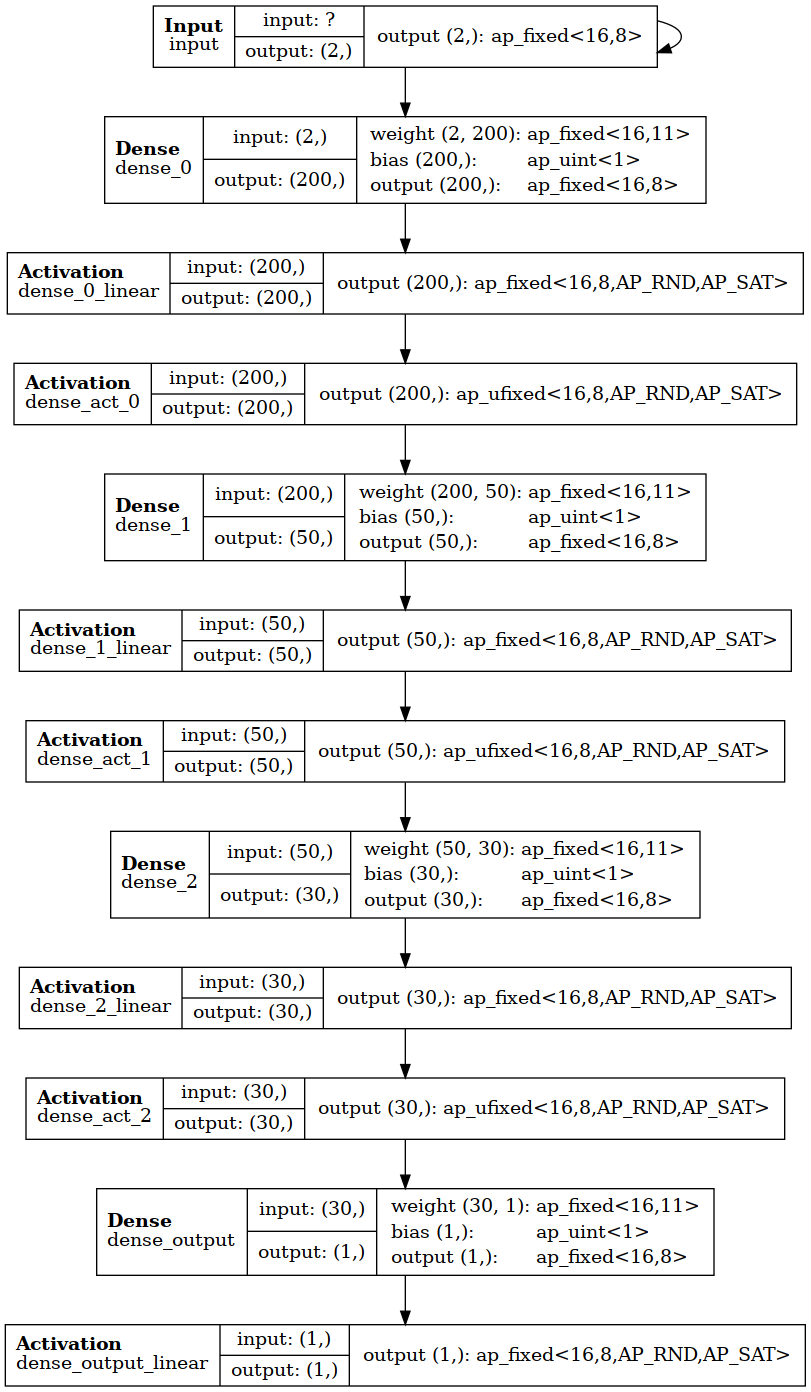

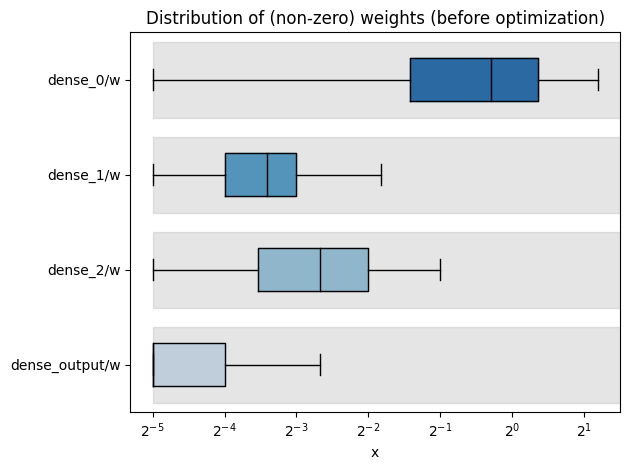

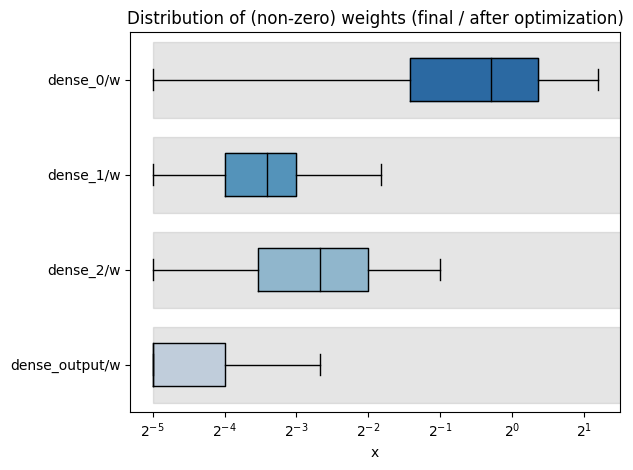

In [46]:
## Hls4ml Project root directory

compile_outdir = working_directory + "2inputs_dummy_Qmodel_fuckme_re8_compile/"
import plotting
hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

hls_config_q = hls4ml.utils.config_from_keras_model(Qmodel, granularity='name')

hls_config_q['Model']['ReuseFactor'] = 8
hls_config_q['Model']['Precision'] = 'ap_fixed<16,8>'
hls_config_q['Model']['Strategy'] = 'resource'
hls_config_q['LayerName']['dense_0']['ReuseFactor'] = 8
hls_config_q['LayerName']['dense_1']['ReuseFactor'] = 8
hls_config_q['LayerName']['dense_2']['ReuseFactor'] = 8
#hls_config_q['LayerName']['dense_output']['Precision'] = 'ap_fixed<32,16>'
hls_config_q['LayerName']['input']['Precision'] = 'ap_fixed<16,8>'
hls_config_q['LayerName']['dense_0']['Precision'] = 'ap_fixed<16,8>'
#hls_config_q['LayerName']['dense_output']['Strategy'] = 'resource'

plotting.print_dict(hls_config_q)

cfg_q = hls4ml.converters.create_config(backend='Vivado')
cfg_q['IOType']     = 'io_parallel' 
#cfg_q['IOType']     = 'io_stream'
cfg_q['HLSConfig']  = hls_config_q
cfg_q['KerasModel'] = Qmodel
cfg_q['OutputDir']  = compile_outdir 
cfg_q['XilinxPart'] = 'xcvu160-flgb2104-2-e'
  
hls_model_q = hls4ml.converters.keras_to_hls(cfg_q)
hls4ml.model.profiling.numerical(model=Qmodel, hls_model=hls_model_q)
hls4ml.utils.plot_model(hls_model_q, show_shapes=True, show_precision=True, to_file=None) 

## Create the actual HLS projec Model

In [47]:
hls_model_q.compile()

Writing HLS project
Done


## C-simulation

In [48]:
print(f"The original input is\n :{X} ")
print(f"The original label is\n  :{Y}")
X = X.astype(np.float32)
print(hls_model_q.predict(X))
print(hls_model_q.predict(np.array( 
   [
    [1,1] ,
    [2,2] ,
    [4,4],
    [8,8],
    [0,8],
    [8,0],
    [-15,0],
    [0,-15],
    [-15,-15],
    [32,0], 
    [0,32],
    [32,32],
    #[0,25.5], 
    #[25.5,25.5], 
   ] 
   ,dtype = np.float32
)))

The original input is
 :[[0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]] 
The original label is
  :[[1]
 [2]
 [3]
 [4]]
[[0.       ]
 [1.8945312]
 [2.8515625]
 [3.8828125]]
[[ 3.8828125]
 [ 7.9335938]
 [15.9609375]
 [31.96875  ]
 [15.964844 ]
 [23.859375 ]
 [ 7.9960938]
 [17.925781 ]
 [10.8984375]
 [32.59375  ]
 [25.003906 ]
 [12.160156 ]]


## High Level Synthese

In [49]:
hls_model_q.build(csim=False)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2700185 on Thu Oct 24 18:45:48 MDT 2019
  **** IP Build 2699827 on Thu Oct 24 21:16:38 MDT 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /tools/xilinx/ISE_EDK/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/tools/xilinx/ISE_EDK/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'updyh' on host 'work5.itiv.kit.edu' (Linux_x86_64 version 4.18.0-425.19.2.el8_7.x86_64) on Sat Apr 22 05:42:59 CEST 2023
INFO: [HLS 200-10] On os "Rocky Linux release 8.7 (Green Obsidian)"
INFO: [HLS 200-10] In directory '/home/updyh/Git/displaced_vertex_cnn_accelerator/Dummy_input2_run/2inputs_dummy_Qmodel_fuckme_re8_compile'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Opening project '/home/updyh/Git/displaced_vertex_cnn_accelerator/Dummy_input2_run/2inputs_dummy_

{'EstimatedClockPeriod': '4.375',
 'BestLatency': '47',
 'WorstLatency': '51',
 'IntervalMin': '10',
 'IntervalMax': '10',
 'BRAM_18K': '645',
 'DSP48E': '1452',
 'FF': '86515',
 'LUT': '183372',
 'URAM': '0',
 'AvailableBRAM_18K': '6552',
 'AvailableDSP48E': '1560',
 'AvailableFF': '1852800',
 'AvailableLUT': '926400',
 'AvailableURAM': '0'}

## Read the Vivado Report 

In [50]:
hls4ml.report.read_vivado_report(compile_outdir)

Found 1 solution(s) in /home/updyh/Git/displaced_vertex_cnn_accelerator/Dummy_input2_run/2inputs_dummy_Qmodel_fuckme_re8_compile//myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Sat Apr 22 05:58:56 2023

* Version:        2019.2 (Build 2698951 on Thu Oct 24 19:15:34 MDT 2019)
* Project:        myproject_prj
* Solution:       solution1
* Product family: virtexu
* Target device:  xcvu160-flgb2104-2-e


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  | 5.00 ns | 4.375 ns |   0.62 ns  |
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+----------+----------+-----+-----+----------+
    |  Latency (cycles) |  Latency (absolute) |  Interval | Pipeline |
    |   min   |   max 